In [77]:
import numpy as np
print("np: ", np.__version__)
import matplotlib
print("mpl: ", matplotlib.__version__)
import numpy as np
import scipy.stats as sst
import scipy as sp
print("sp: ", sp.__version__)
import matplotlib.pylab as plt
import seaborn as sns
#from math import 
import scipy.spatial.distance as ssp
import pandas as pd


from IPython.display import Image
from IPython.display import display
from IPython.display import SVG

## Maybe this imports will be neccesary in the future
#import helpers.theo_variogram_fct as vario
#import helpers.th_cov_func as nest_vario
#from ipywidgets import interact,Checkbox,Text,VBox
#import helpers.kriging as kri
#import helpers.variogram as variokri
##

np:  1.16.5
mpl:  3.1.1
sp:  1.3.1


In [78]:
#import data iron concentration
data = pd.read_csv("data_iquique/data_fe.csv")
xyz = data.to_numpy()
#print(xyz[:3])

#reduce coordenate numbers
xyz[:,0]= xyz[:,0] - min(xyz[:,0])
xyz[:,1]= xyz[:,1] - min(xyz[:,1])
#print(xyz[:3])

#to define grid (to match sample points with each cell of grid)
delta_x = 1000        #meters (it depends on the data set dimensions)
delta_y = delta_x     #meters. To keep square cells

(539, 2)


Text(0, 0.5, 'Y [m]')

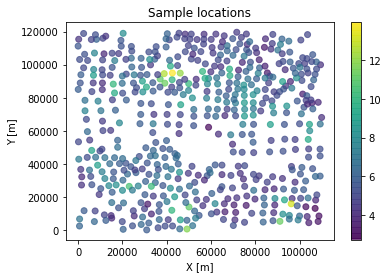

In [79]:
#Scatter plot of samples
xy = xyz[:,0:2]
print(xy.shape)

x = xyz[:,0] #in case of...
y = xyz[:,1]
z = xyz[:,2]


plt.scatter(x, y, c=z, alpha=0.7)
plt.colorbar()
plt.title('Sample locations')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

539
328


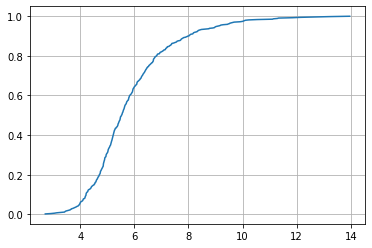

In [80]:
#Calculates the cummulative distribution function of data z
def function_cdf(z):
    s = np.sort(z)
    z_values = np.unique(s)
    pdf = []
    for i in range(len(z_values)-1):
        pdf.append(len(z[(s >= z_values[i]) & (s < z_values[i+1])])/len(s))
    cdf = np.cumsum(pdf)
    cdf = np.append(cdf,1)
    return z_values, cdf

values_cdf, cdf = function_cdf(z)

print(z.size)
print(values_cdf.size)

#Original data
plt.figure()
plt.grid()
plt.plot(values_cdf, cdf)

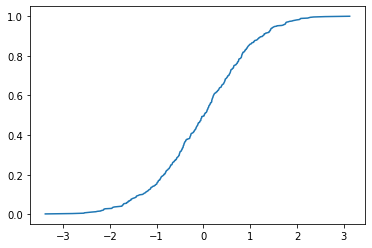

In [81]:
#Data to be transformed
normal_data = np.array(np.random.normal(0,1,len(z)))
values_cdf_normal, cdf_normal = function_cdf(normal_data)

plt.figure()
plt.plot(values_cdf_normal, cdf_normal)

In [82]:
#Normalization of data z
norm_z = []
for value in z:
    pos = np.where(values_cdf==value)[0][0]                        #finds cummulative probability of the value
    inter = sp.interpolate.interp1d(cdf_normal,values_cdf_normal)  #To make it continous
    norm_z.append(inter(cdf[pos]))                                 #looks for the normed value with the same cumm probability
norm_z = np.array(norm_z)

z = norm_z#We want to continue with this transformed data otherwise comment line!

print('max z value =', max(z))
print('min z value =', min(z))
print(z.shape) #to check output dimensions

max z value = 3.1267482080313536
min z value = -3.3838387333387083
(539,)


total number of distances = 144991
max distance = 155400.2 [m]
min distance = 1419.2 [m]
dimensions of D =  (539, 539)


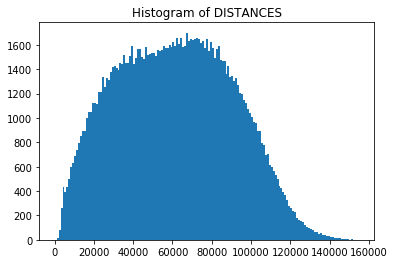

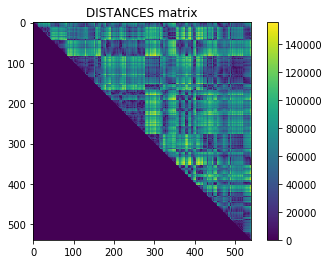

In [83]:
H = ssp.pdist(xy, metric='euclidean')
D = ssp.squareform(H)
upper = np.triu(D)
upper_vector = np.matrix.flatten(upper)
upper_vector = upper_vector[upper_vector>0]
print("total number of distances =", upper_vector.shape[0])
plt.hist(upper_vector, bins = np.arange(0, np.round(max(H),0)+1, delta_x))
plt.title("Histogram of DISTANCES")
print("max distance =",np.round(max(H),1),"[m]")
print("min distance =",np.round(min(H),1),"[m]")
print("dimensions of D = ",upper.shape)
plt.show()

plt.imshow(upper)
plt.title("DISTANCES matrix")
plt.colorbar()
plt.show()

### Correlogram

In [84]:
n = np.linspace(1000,30000,30)
bins = np.array(n)
print(bins)
print(type(bins))

[ 1000.  2000.  3000.  4000.  5000.  6000.  7000.  8000.  9000. 10000.
 11000. 12000. 13000. 14000. 15000. 16000. 17000. 18000. 19000. 20000.
 21000. 22000. 23000. 24000. 25000. 26000. 27000. 28000. 29000. 30000.]
<class 'numpy.ndarray'>


In [85]:
ixs = []    # for measurement values at point 0
ixs_h = []  # for measurement values at point 1
rs = []     # for rs in each bin
d_mean = [] # for mean distances

ix = np.array(np.where(np.logical_and(D>bins[0], D<=bins[1])))
print(ix.shape)

(2, 26)


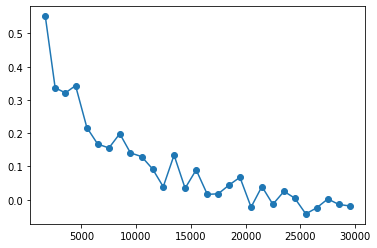

In [86]:
F = z

for cur_i in range(0, len(bins)-1):
    ix = np.where(np.logical_and(D>bins[cur_i], D<=bins[cur_i+1]))
    d_mean.append(D[ix].mean())
    F_0 = F[ix[0]]
    F_1 = F[ix[1]]
    r = np.corrcoef(F_0, F_1)[1,0]
    rs.append(r)
    ixs.append(F_0)
    ixs_h.append(F_1)

#plot
plt.plot(d_mean,
         rs,
        'o-')

### Variogram

In [87]:
Z1, Z2 = np.meshgrid(F, F)
sem_var = (Z1-Z2)**2.
sem_vars = []
co_vars = []
sem_vars_v2 = []
n_pts = []

for cur_i_bin, cur_bin in enumerate(bins[:-1]):
    #print cur_i_bin, cur_bin
    ix = np.where(np.logical_and(D>bins[cur_i_bin], D<=bins[cur_i_bin+1]))
#     print len(ix)
#     print "  ", ix[0].shape, ix[0].min(), ix[0].max()
#     print "  ", ix[1].shape, ix[1].min(), ix[1].max()
    
    ## do it via the prepared large matrices
    sem_var_cur = np.sum(sem_var[ix])/(2.0 * ix[0].shape[0])
    #print sem_var_cur
    sem_vars.append(sem_var_cur)
    
    #print"      ",  ix[0].shape[0]
    sem_var_v2 = np.sum((F[ix[1]] - F[ix[0]])**2)/(2.0 * ix[0].shape[0])
    sem_vars_v2.append(sem_var_v2)
    
    mean = F[ix[1]].mean()
    covar = np.sum((F[ix[1]]-mean)* (F[ix[0]]-mean))/( ix[0].shape[0])
    co_vars.append(covar)

(0.0, 1.1129589489847211)

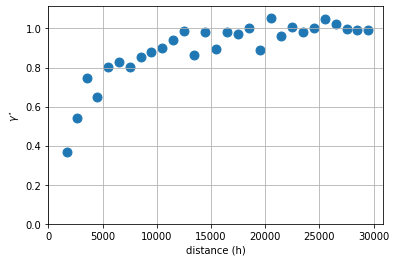

In [88]:
centers =  (bins[:-1] + bins[1:])/2
plt.scatter(d_mean, np.array(sem_vars), s=80)
plt.grid(True)
plt.xlabel('distance (h)')
plt.ylabel('$\gamma^{\star}$')
plt.xlim(0.0,)
plt.ylim(0.0,)

In [12]:
#cual era la idea de esta parte? LA BORRAMOS?
var = np.zeros((len(coord_xy),len(coord_xy)))
for i in range(coord_xy):
    for j in range(i, coord_xy):
        var[i,j] = (data[i] - data[j])**2.

dists_ix = np.triu_indices(D.shape[0], 0)
dists_triu = D[dists_ix]

vars_ix = np.triu_indices(var.shape[0], 0)
vars_triu = var[vars_ix]

plt.scatter(dists_triu, vars_triu, s=40, facecolors='none', edgecolors='b')
plt.xlabel("distance")
plt.ylabel("variance")

NameError: name 'var' is not defined

### Initialize grid (to assign one cell to each sample) EN SESARROLLO, PROBLEMAS DE DIMENSIONES DE MATRICES

(110, 120) (110, 120)
z dim = (110, 120)


IndexError: index 120 is out of bounds for axis 0 with size 110

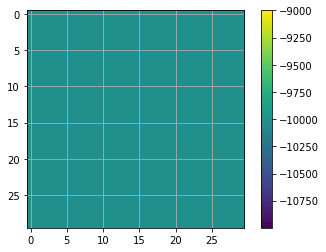

In [114]:
#es mejor definir los deltas en un comienzo, cambiar posterior a terminar codigo.
#delta_x = 1000        #meters (it depends on the data set dimensions)
#delta_y = delta_x     #meters. To keep square cells

nx = int(np.round(max(x)/delta_x))       #number of cell in x-axis
ny = int(np.round(max(y)/delta_y))       #number of cell in y-axis

# print('cells in x =',nx)
# print('cells in y =',ny)
# print('min_x =', min(x),', max_x =',max(x))
# print('min_y =', min(y),', max_y =',max(y))

X, Y = np.mgrid[0:nx:1,0:ny:1]

print(X.shape,Y.shape)

#Initialize the entire matrix with -9999
Z = np.zeros([X.shape[0],X.shape[1]])-9999
print('z dim =',Z.shape)
plt.imshow(Z[:30,:30])
plt.colorbar()
plt.grid(True)
print(Z[120][0])

#Assig value to Z
i=0;

while i< x.shape[0]:
    x_i = int(np.round(x[i]/delta_x,0))
    y_i = int(np.round(y[i]/delta_y,0))
    Z[x_i][y_i] = z[i]
    i = i+1
    print(i,z[i])

print('max z value =', max(z))
print('min z value =', min(z))

plt.imshow(Z)

In [50]:
print(x.shape[0])

539


### Random path function

In [ ]:
### EN DESARROLLO!!!

nx = 1 + np.round(max(x)/delta_x)       #number of cell in x-axis
ny = 1 + np.round(max(y)/delta_y)        #number of cell in y-axis

n_sample = 150 #sample amount
A = np.random.rand(nx,ny) #Define nx x ny dimension initial matrix with values in a normal distribution u=0, var=1
sigma = 1 #quizas esto no sea necesario
mu = 0    #quizas esto no sea necesario
print (A.shape)


# fuction to create random vector of sample locations
def random_loc_vec(nx,l): # range of number [0,nx)
    loc_vector = np.random.randint(nx, size=(l,2))
    unique = np.unique(loc_vector, axis=0)
    i=1
    while len(unique) < len(loc_vector) and i<100:     #i is to avoid infinite loop in case.
        dif = len(loc_vector) - len(unique)
        add = np.random.randint(nx, size=(dif,2))
        unique = np.concatenate((unique,add), axis=0)
        unique = np.unique(unique, axis=0)
        i+=1
    unique = np.array(unique)
    return unique

#vector with unique location
location_v= random_loc_vec(nx, n_sample)
print(location_v.shape)


#get global coordenates
coord_xy = np.array(np.zeros((len(location_v),2)))
for i in range(len(location_v)):
    coord_xy[i][0] = location_v[i][0]*delta_x*3/2 
    coord_xy[i][1] = location_v[i][1]*delta_y*3/2
# print(coord_xy[:3])

#Get z values vector
z_values = np.matrix([A[i[0], i[1]] for i in location_v])  #np.matrix to get a matrix transposable
z_values = np.array(z_values.T)

#unify XYZ real world coordenates matrix
xyz= np.concatenate((coord_xy, z_values), axis=1)